In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from scipy.special import logsumexp


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna

In [5]:
def ilr_transform(X):
    epsilon = 1e-10
    X = X + epsilon
    return np.log(X / np.mean(X, axis=1, keepdims=True))

t2d = pd.read_csv("../qiime2/relative-frequency/genus_transposed.tsv", sep="\t")
t2d = t2d.rename(columns={"Unnamed: 0":"sample-id"})

sample_ids = t2d.iloc[:, 0]
otu_values = t2d.iloc[:, 1:].values

X_data = ilr_transform(otu_values)

metadata = pd.read_csv("../qiime2/our-metadata.tsv", sep="\t")
Y_labels = t2d.merge(metadata, on="sample-id")['t2d'].apply(lambda x: 1 if x=='Yes' else 0).values

In [10]:
X_tensor = torch.tensor(X_data, dtype=torch.float32)
y_tensor = torch.tensor(Y_labels, dtype=torch.long)

## Baseline VAE Architecture

In [50]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, z_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        mean = self.fc2_mean(h1)
        logvar = self.fc2_logvar(h1)
        return mean, logvar

In [52]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, z):
        h1= torch.relu(self.fc1(z))
        recon_x = self.fc2(h1)
        return recon_x

In [82]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden_dim, input_dim)
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        recon_x = self.decoder(z)
        return recon_x, mean, logvar

In [56]:
def vae_loss(recon_x, x, mean, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return MSE + KLD

In [58]:
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [84]:
def objective(trial):
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    latent_dim = trial.suggest_categorical('latent_dim', [10, 20, 50])
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)

    model = VAE(input_dim=X_data.shape[1], hidden_dim=hidden_dim, z_dim=latent_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    writer = SummaryWriter(log_dir=f'runs/optuna/h{hidden_dim}_z{latent_dim}_lr{lr}')

    num_epochs = 50
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in loader:
            data = batch[0].to(device)
            optimizer.zero_grad()
            
            recon_batch, mu, logvar = model(data)
            loss = vae_loss(recon_batch, data, mu, logvar)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        average_loss = epoch_loss / len(loader.dataset)
        writer.add_scalar('Loss/train', average_loss, epoch)
    
    writer.close()
    return average_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print(f'Best hyperparameters: {study.best_params}')

[I 2025-03-09 14:43:21,542] A new study created in memory with name: no-name-bb1fe5a5-f0ef-42fa-81f5-7a5d63a6c487
/var/folders/02/jj1jlsn97sj550kl_82_8lp40000gn/T/ipykernel_13218/3894664526.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
[I 2025-03-09 14:43:22,554] Trial 0 finished with value: 7715.104230887793 and parameters: {'hidden_dim': 256, 'latent_dim': 10, 'lr': 0.0006712442189214513}. Best is trial 0 with value: 7715.104230887793.
[I 2025-03-09 14:43:23,570] Trial 1 finished with value: 14835.21218017879 and parameters: {'hidden_dim': 256, 'latent_dim': 50, 'lr': 1.5138191389859e-05}. Best is trial 0 with value: 7715.104230887793.
[I 2025-03-09 14:43:24,594] Trial 2 finished with value: 8639.507379007398 and parameters: {'hidden_dim': 256, 'latent_dim': 50, 'lr': 0.00

Best hyperparameters: {'hidden_dim': 256, 'latent_dim': 10, 'lr': 0.0006712442189214513}


In [90]:
#Best hyperparameters after Optuna
hidden_dim = 256
latent_dim = 10
lr = 0.0006
num_epochs = 50


model = VAE(input_dim=614, hidden_dim=hidden_dim, z_dim=latent_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)


loader = torch.utils.data.DataLoader(X_tensor, batch_size=64, shuffle=True)
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch in loader:
        data = batch
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        
        loss = vae_loss(recon_batch, data, mu, logvar)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(loader)}')

with torch.no_grad():
    model.eval()
    mu, _ = model.encoder(X_tensor)


Epoch 1/50, Loss: 6285256.990384615
Epoch 2/50, Loss: 1523715.9375
Epoch 3/50, Loss: 1055854.1298076923
Epoch 4/50, Loss: 914147.5096153846
Epoch 5/50, Loss: 879200.7596153846
Epoch 6/50, Loss: 860497.5528846154
Epoch 7/50, Loss: 849436.3076923077
Epoch 8/50, Loss: 840250.6057692308
Epoch 9/50, Loss: 832750.4086538461
Epoch 10/50, Loss: 825953.2259615385
Epoch 11/50, Loss: 820044.6538461539
Epoch 12/50, Loss: 814193.4471153846
Epoch 13/50, Loss: 808721.4615384615
Epoch 14/50, Loss: 802186.7692307692
Epoch 15/50, Loss: 795582.0336538461
Epoch 16/50, Loss: 787801.875
Epoch 17/50, Loss: 778745.2572115385
Epoch 18/50, Loss: 765327.25
Epoch 19/50, Loss: 748688.9567307692
Epoch 20/50, Loss: 727519.4831730769
Epoch 21/50, Loss: 706327.0096153846
Epoch 22/50, Loss: 689016.8125
Epoch 23/50, Loss: 676352.2644230769
Epoch 24/50, Loss: 664508.2932692308
Epoch 25/50, Loss: 649656.6923076923
Epoch 26/50, Loss: 635606.6610576923
Epoch 27/50, Loss: 624426.2932692308
Epoch 28/50, Loss: 616917.298076923

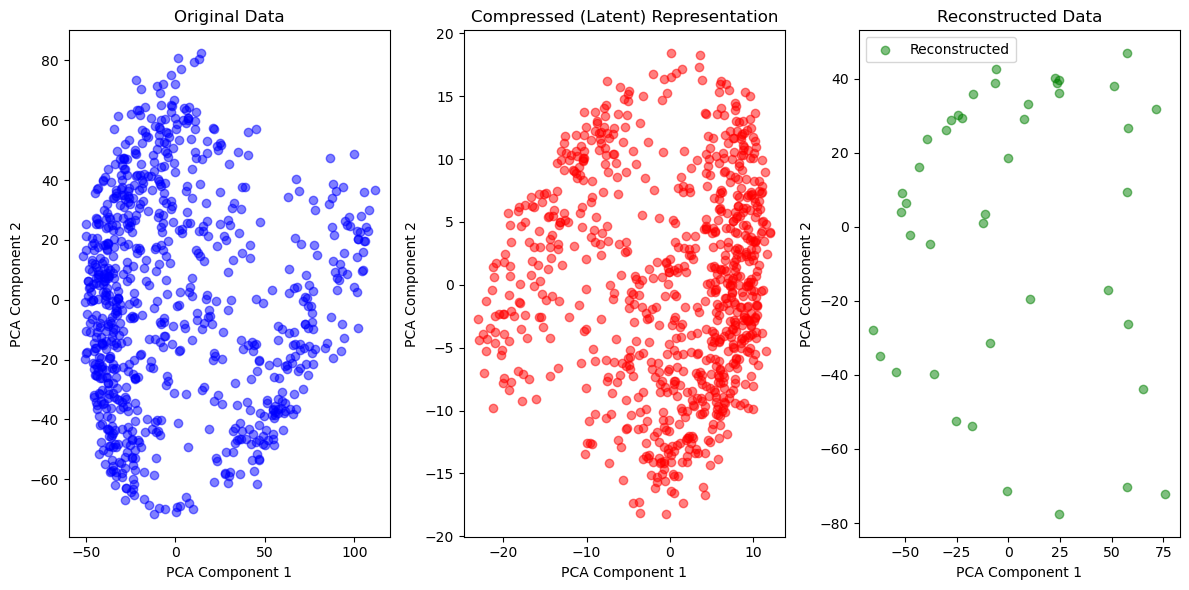

In [92]:
from sklearn.decomposition import PCA

pca_original = PCA(n_components=2)
X_2d = pca_original.fit_transform(X_tensor.numpy())

pca_latent = PCA(n_components=2)
mu_2d = pca_latent.fit_transform(mu.numpy())

pca_reconstructed = PCA(n_components=2)
reconstructed_2d = pca_reconstructed.fit_transform(recon_batch.detach().numpy())

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(X_2d[:, 0], X_2d[:, 1], color='blue', alpha=0.5, label="Original")
plt.title('Original Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.subplot(1, 3, 2)
plt.scatter(mu_2d[:, 0], mu_2d[:, 1], color='red', alpha=0.5, label="Compressed")
plt.title('Compressed (Latent) Representation')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.subplot(1, 3, 3)
plt.scatter(reconstructed_2d[:, 0], reconstructed_2d[:, 1], color='green', alpha=0.5, label="Reconstructed")
plt.title('Reconstructed Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.legend()
plt.show()


In [108]:
recon_batch

tensor([[  4.4715, -11.5232, -10.3190,  ..., -16.7726, -17.2697, -17.2283],
        [  3.7100, -10.9232,   0.9201,  ..., -16.8715, -16.7372, -16.7070],
        [  4.4109,  -7.4542,  -7.1710,  ..., -16.6963, -16.6221, -16.6718],
        ...,
        [  4.3001,  -8.9069,  -7.5635,  ..., -15.7641, -15.9208, -16.1020],
        [  4.4297,  -9.2657,  -6.8758,  ..., -16.6211, -16.4423, -16.3930],
        [  4.5998, -11.1553,  -9.5191,  ..., -16.6659, -16.9116, -16.6395]],
       grad_fn=<AddmmBackward0>)

In [122]:
mu

tensor([[-1.0713, -5.0357, 14.5564,  ..., -5.4631,  7.8051, 15.4565],
        [-0.5986, -6.5914, 15.4278,  ..., -5.6489,  6.8178, 14.9010],
        [ 0.6204, -3.3405, 12.1543,  ..., -5.8342,  9.1779, 12.9709],
        ...,
        [ 2.6080, -2.0656,  9.5362,  ..., -7.2999,  8.7716, 12.0812],
        [ 5.4936,  4.4589,  3.9288,  ..., -6.1178, 10.8359,  9.0108],
        [ 2.4963, -1.6948,  9.1604,  ..., -6.1998,  9.4910, 11.5107]])

In [124]:
X_output = mu.numpy()

In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns


X_train, X_test, y_train, y_test = train_test_split(X_output, Y_labels, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.43      0.57        60
           1       0.74      0.94      0.83       103

    accuracy                           0.75       163
   macro avg       0.78      0.69      0.70       163
weighted avg       0.77      0.75      0.73       163



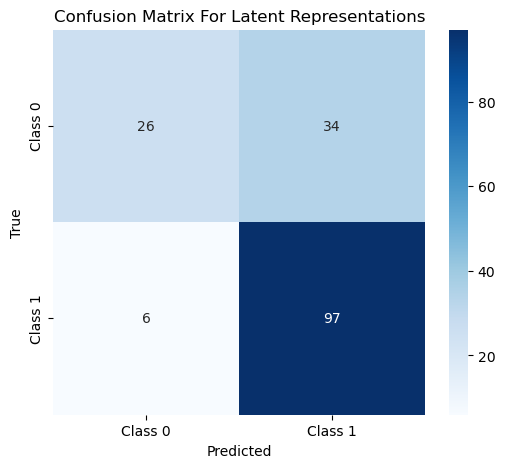

In [128]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix For Latent Representations')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.67      0.68        60
           1       0.81      0.83      0.82       103

    accuracy                           0.77       163
   macro avg       0.76      0.75      0.75       163
weighted avg       0.77      0.77      0.77       163



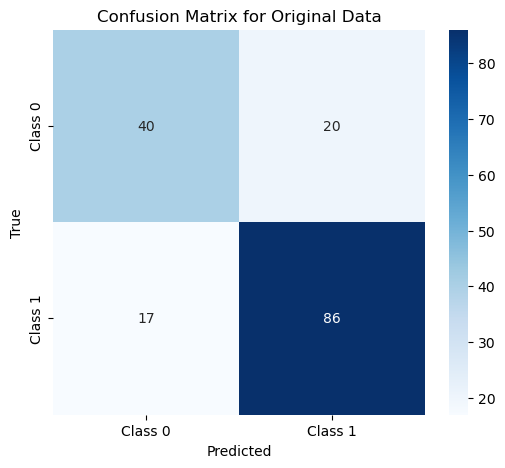

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor.numpy(), Y_labels, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=10000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Original Data')
plt.show()

## Baseline VAE + Classifiers

In [136]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

classifiers = {
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

def evaluate_classifiers(X_train, X_test, y_train, y_test):
    results = {}
    
    for clf_name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        results[clf_name] = report['accuracy']
        
    return results

X_train_orig, X_test_orig, y_train, y_test = train_test_split(X_tensor, Y_labels, test_size=0.2, random_state=42)
X_train_recon, X_test_recon, _, _ = train_test_split(mu.numpy(), Y_labels, test_size=0.2, random_state=42)

original_results = evaluate_classifiers(X_train_orig, X_test_orig, y_train, y_test)
reconstructed_results = evaluate_classifiers(X_train_recon, X_test_recon, y_train, y_test)

print("Classifier Performance on Original Data:")
for clf, accuracy in original_results.items():
    print(f"{clf}: Accuracy = {accuracy:.4f}")

print("\nClassifier Performance on Reconstructed Data with baseline VAE:")
for clf, accuracy in reconstructed_results.items():
    print(f"{clf}: Accuracy = {accuracy:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Classifier Performance on Original Data:
Logistic Regression: Accuracy = 0.7791
K-Nearest Neighbors: Accuracy = 0.7423
Support Vector Machine: Accuracy = 0.7791
Random Forest: Accuracy = 0.7975
Gradient Boosting: Accuracy = 0.8405

Classifier Performance on Reconstructed Data with baseline VAE:
Logistic Regression: Accuracy = 0.7362
K-Nearest Neighbors: Accuracy = 0.6687
Support Vector Machine: Accuracy = 0.7178
Random Forest: Accuracy = 0.6933
Gradient Boosting: Accuracy = 0.6319
